# Copernicus Climate Change Service (C3S) - Upper Air Data Service 

    This IPython Notebook is intended for demonstration purposes and example usage of the Homogenization software for Radiosonde humidity data.
    For further information please refer to the Deliverable Document or the script `raso_adj_cdm_v0.py` on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/adjust).

 Table of Contents:
* [Downloading of data](#Downloading-of-data)
* [Investigating the data](#Investigating-the-data)
* [Running the Homogenization software](#Running-the-Homogenization-software)
* [Investigating results](#Investigating-results)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')

In [3]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

# Downloading of data
For demonstration purposes, example data is allready available but we show here how to download these data from the CDS.

A typical request should contain:
1. **statid** - the Station Identifier
2. **date** - datetime selection YYYYMMDD
3. **pressure_level** - selection of pressure levels
4. **variable** - selection of variables 
5. **fbstats**  - feedback information from reanalysis

In [8]:
#
# Set to 'True' to enable download, example data is provided
#
if False:    
    import requests, zipfile, io, os, time
    t0 = time.time()
    #
    # This is for Python 3+
    #
    # http://early-upper-air.copernicus-climate.eu
    r = requests.post('http://srvx8.img.univie.ac.at:8004',
                      headers={'content-type': 'application/json'},
                      json={"statid": "72357",
                            "date": [19900101, 20181231],
                            "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                               50000, 70000, 85000, 92500, 100000],
                            "variable": ["temperature", "relative_humidity"],
                            "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                            },
                      stream=True)
    #
    # Check for known Error Message
    #
    if r.status_code != requests.codes.ok:
        print(r.text)
        raise RuntimeError("Something is not correct with the request")
    #
    # Create directory
    #
    if not os.path.isdir('./example_data'):
        os.makedirs('./example_data')
    #
    # Unzip the Data Stream
    #
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        print("Retreived files: ")
        print(z.namelist())
        z.extractall(path='./example_data')
    except:
        print(r.text)
        print("Error in request")    
    print("Time elapsed: ", time.time()-t0, "s")
else:
    print("Using the data in ./example_data")
    print(os.listdir('./example_data'))

Using the data in ./example_data
['dest_72357_air_temperature.nc', 'dest_72357_relative_humidity.nc']


Another Way can be use a Linux tool called `curl` to download a zipfile:
```bash
curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"72357","date":[19900101,20181231],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://early-upper-air.copernicus-climate.eu
```
and then unzip the contents in the directory
```bash
unzip -o example_data/download.zip
```

In [6]:
# Show the new downloaded files in example_data directory
!tree -Dhr

.
├── [1.0K Jan 15 17:01]  README.md
├── [ 40K Jan 27  9:49]  raso_adj_cdm_v0.py
├── [ 94K Jan 27 15:42]  Example_Homogenization.ipynb
└── [  80 Jan 24 11:53]  example_data
    ├── [5.5M Jan 27 15:41]  dest_72357_relative_humidity.nc
    └── [5.6M Jan 27 15:41]  dest_72357_air_temperature.nc

1 directory, 5 files


In [7]:
# Example output of retrieved NetCDF file
!ncdump -h example_data/dest_72357_air_temperature.nc

netcdf dest_72357_air_temperature {
dimensions:
	obs = 334367 ;
	string5 = 5 ;
	trajectory = 21329 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "K" ;
		bias_estimate:coordinates = "lat lon time plev" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "air_temperature" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
	float lat(obs) ;
		lat:cdmname = "observations_table/latitude" ;
		lat:units = "degree_north" ;
		lat:standard_name = "latitude" ;
	float lon(obs) ;
		lon:cdmname = "observations_table/longitude" ;
		lon:units = "degree_east" ;
		lon:standard_name = "longitude" ;
	float obs_minus_an(obs) ;
		obs_minus_an:cdmname = "era5fb/an_depar@body" ;
		obs_minus_an:units = "K" ;
		obs_minus_an:coordinates = "lat lon time plev" ;
		obs_minus_an:cdsname = "obs_minus_an" ;
		obs_minus_an:standard_name = "air_temperature" ;
		obs_minus_an:long_name = "ERA5 reanalysis obs_minus_

# Investigating the data

At the moment (01.2020), the database is at version 0, however, the data files seen here will be very similar to the ones delivered by the end of the contract.

The following shows how to open these files and read information. These are very common routines for data analysis. NetCDF can be read by numerous packages in Python. Xarray proves to be the most useful at the moment.


In [124]:
import xarray as xr

In [125]:
ident = '72357'  # Station Identifier

In [126]:
tdata = xr.load_dataset('example_data/dest_{}_air_temperature.nc'.format(ident))

In [127]:
rdata = xr.load_dataset('example_data/dest_{}_relative_humidity.nc'.format(ident))

## Temperature data in Xarray

Notice that there are the following variables:
* bias_estimate - Reanalysis Bias estimate
* obs_min_an - Analysis Departures
* obs_min_bg - First Guess Departures
* ta - Temperature observations

In [128]:
tdata

<xarray.Dataset>
Dimensions:           (obs: 334367, trajectory: 21329)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 1000.0 2000.0 3000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 -1.340332 -0.295052 ... -0.02625 nan
    obs_minus_an      (obs) float32 0.280334 -2.471445 ... 1.084904 nan
    obs_minus_bg      (obs) float32 0.427206 -3.270976 -1.466765 ... 1.18198 nan
    ta                (obs) float32 219.3 214.3 213.3 ... 273.35 279.75 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 21328 21328 21328 21328 21328
    trajectory_label  (trajectory) |S5 b'00551' b'00552' ... b'23679' b'23680'
Attributes:
    primary_id:    0-20000-0-72357
    station_name:  NORMAN/M

## Relative humidity 

In [129]:
rdata

<xarray.Dataset>
Dimensions:           (obs: 334367, trajectory: 21329)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 1000.0 2000.0 3000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    hur               (obs) float32 nan nan nan nan ... 0.838794 0.654979 nan
    obs_minus_an      (obs) float32 nan nan nan nan ... -0.054035 -0.091665 nan
    obs_minus_bg      (obs) float32 nan nan nan nan ... -0.050184 -0.050518 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 21328 21328 21328 21328 21328
    trajectory_label  (trajectory) |S5 b'00551' b'00552' ... b'23679' b'23680'
Attributes:
    primary_id:    0-20000-0-72357
    station

In [133]:
# Relative Humidity variable
rdata.hur

<xarray.DataArray 'hur' (obs: 334367)>
array([     nan,      nan,      nan, ..., 0.838794, 0.654979,      nan],
      dtype=float32)
Coordinates:
    lat      (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lon      (obs) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    plev     (obs) float32 1000.0 2000.0 3000.0 ... 85000.0 92500.0 100000.0
    time     (obs) datetime64[ns] 1990-01-01 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs
Attributes:
    cdmname:        observations_table/observation_value
    units:          1
    standard_name:  relative_humidity
    cdsname:        relative_humidity

## Plotting

Text(0.5, 1.0, 'Radiosonde Temperature Observations from 72357 at 500 hPa')

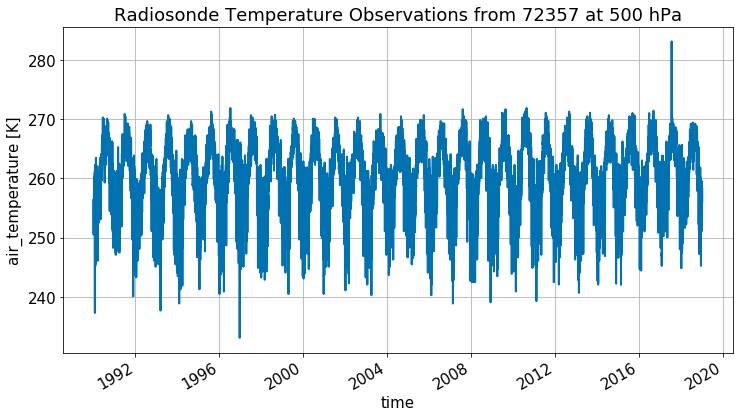

In [19]:
# Selecting only data for 500 hPa
# notice that the dimension is not time yet, but obs
tdata.ta.sel(obs=(tdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde Temperature Observations from {} at 500 hPa".format(ident))

Text(0.5, 1.0, 'Radiosonde relative humidity Observations from 72357 at 500 hPa')

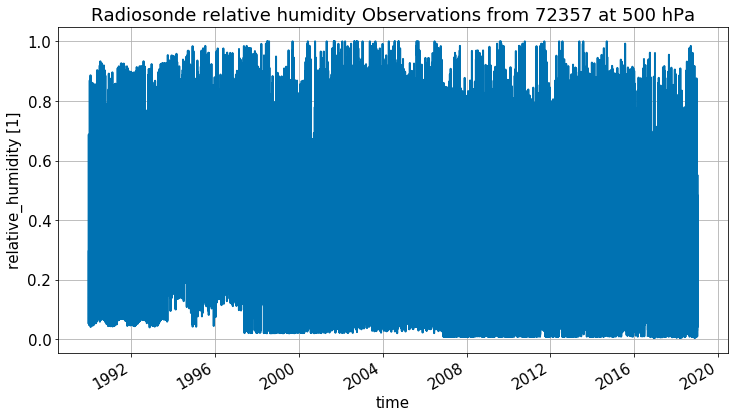

In [18]:
rdata.hur.sel(obs=(rdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde relative humidity Observations from {} at 500 hPa".format(ident))

In [143]:
rdata.sel(obs=(rdata.plev==50000)).sel(obs=rdata.hur.sel(obs=(rdata.plev==50000)).swap_dims({'obs':'time'}).time.to_index().duplicated(keep=False))

<xarray.Dataset>
Dimensions:           (obs: 3190, trajectory: 21329)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 50000.0 50000.0 50000.0 ... 50000.0 50000.0
    time              (obs) datetime64[ns] 2010-07-27 ... 2018-12-26T23:18:00
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    hur               (obs) float32 0.488463 0.488463 ... 0.465224 0.465224
    obs_minus_an      (obs) float32 -0.11969 -0.11969 ... 0.128478 0.128478
    obs_minus_bg      (obs) float32 -0.075467 -0.075467 ... 0.142709 0.142709
    trajectory_index  (obs) int32 15227 15227 15383 15383 ... 21317 21319 21319
    trajectory_label  (trajectory) |S5 b'00551' b'00552' ... b'23679' b'23680'
Attributes:
    primary_id:    0-20000-0-72357
    station_name:  

# Running the Homogenization Software

The following steps are completed automatically within this script:
1. Read data (`ifile`)
2. Convert to `time x pressure` cubes
3. Select only standard times (`0, 12`)
4. Look for required variables
    - Need observations and obs_minus_an
5. Calculate test statistics
6. Detect Breakpoints
7. Calculate Adjustments
8. Return/Write data


The Python script can also be run from the command line:
```bash
>>> python raso_adj_cdm_v0.py -h

Run standardized radiosonde homogenisation software on CDM compliant file

raso_adj_cdm_v0.py -h -f [file] -o [name] 

Options:
    -h              Help
    --help      
    -f []           Input CDM compliant file
    --file []       
    -o []           Output name
    --output []
    
Optional Keyword Options:
    --thres []      Threshold value for SNHT, default: 50

```

It is also possible to import the script like a module and execute some functions individually or the `main`.

## Import script as Module

Intended for Notebook use

In [4]:
import raso_adj_cdm_v0

### Usage information

In [5]:
raso_adj_cdm_v0.usage()


Run standardized radiosonde homogenisation software on CDM compliant file

/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py -h -f [file] -o [name] 

Options:
    -h              Help
    --help      
    -f []           Input CDM compliant file
    --file []       
    -o []           Output name
    --output []
    
Optional Keyword Options:
    --thres []          Threshold value for SNHT, default: 50
    --window []         Moving Window for SNHT, default: 1470 (in days, 4 years)
    --missing []        Maximum allowed missing values in window, default: 600 (in days)
    --min_levels []     Minimum required levels for significant breakpoint, default: 3
    --dist []           Minimum distance between breakpoints, default: 730 (in days, 2 years)
    --sample_size []    Minimum sample size for statistics, default: 130 (in days)
    --borders []        Breakpoint zone, default: 90 (in days)
    --ratio []          Use ratio instead of d

### Execute Main

the `main` function 

    call signature:
    raso_adj_cdm_v0.main(ifile=None, ofile=None, **kwargs)

needs to be called with a `ifile` string, that is a path to one file or multiple files from one radiosonde. Either specify an output filename or a modified inputfile name will be used.

As described in the `usage` it requires inputdata and Keyword-Options. To return the data directly to the Notebook give the `donotwrite=True` Argument, as seen below.

In [6]:
import importlib as imp

In [26]:
imp.reload(raso_adj_cdm_v0)

<module 'raso_adj_cdm_v0' from '/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py'>

In [27]:
data = raso_adj_cdm_v0.main(ifile="example_data/*.nc", donotwrite=True, adddate=True, interpolate_missing=True)

[2020-01-28T14:02:28.384915] [INFO] Multiple input files:  example_data/*.nc  | # 2
[2020-01-28T14:02:28.508083] [INPUT] example_data/dest_72357_air_temperature.nc ta
[2020-01-28T14:02:28.585595] [INPUT] example_data/dest_72357_relative_humidity.nc hur
[2020-01-28T14:02:28.596788] [CONVERT] Converting to DataCube ...
[2020-01-28T14:02:28.598336] [BKP] Observations obs:334367
[2020-01-28T14:02:28.598403] [BKP] Trajectories obs:334367,trajectory:21329
[2020-01-28T14:02:28.606800] [CONVERT] Selecting only standard pressure levels
[2020-01-28T14:02:31.958409] [CONVERT] Done
[2020-01-28T14:02:31.959258] [TIME] Dates: 1990-01-01 00:00:00  -  2018-12-31 23:04:00 Duplicates: 0
[2020-01-28T14:02:32.262224] [CONVERT] Standard time calculated, Duplicates resolved: 53
[2020-01-28T14:02:32.363133] [CONVERT] Converting to day-night Array [hour x time x pressure]
[2020-01-28T14:02:32.363246] [CHECK] Departures found ta obs_minus_an
[2020-01-28T14:02:32.363286] [CHECK] Departures found ta bias_estimat

In [28]:
data

<xarray.Dataset>
Dimensions:                       (obs: 334367, trajectory: 21329)
Coordinates:
    lat                           (obs) float32 nan nan nan nan ... nan nan nan
    lon                           (obs) float32 nan nan nan nan ... nan nan nan
    plev                          (obs) float64 1e+03 2e+03 ... 9.25e+04 1e+05
    time                          (obs) datetime64[ns] 1990-01-01 ... 2018-12-31T23:04:00
Dimensions without coordinates: obs, trajectory
Data variables:
    ta_bias_estimate              (obs) float32 -1.340332 -0.295052 ... nan
    ta_obs_minus_an               (obs) float32 0.280334 -2.471445 ... nan
    ta_obs_minus_bg               (obs) float32 0.427206 -3.270976 ... nan
    ta                            (obs) float32 219.3 214.3 213.3 ... 279.75 nan
    hur_bias_estimate             (obs) float32 nan nan nan nan ... nan nan nan
    hur                           (obs) float32 nan nan nan ... 0.654979 nan
    hur_obs_minus_an              (obs) float3

# Investigating results

## Departures

## SNHT

## Breakpoints

## Adjustments